# Exploratory Data Analysis of Pneumothorax dataset

* [1. Introduction](#section1)  
* [2. What is Pneumothorax and how can data science help?](#section2)  
* [3. The dataset and how to decode](#section3)  
* [4. Exploring the train metadata](#section4)  
    * [4.1. Gender and Pneumothorax distribution](#section4a)  
    * [4.2. All patients age distribution](#section4b)
    * [4.3. The presence of Pneumothorax at particular ages and genders](#section4c)
    * [4.4. The importance of view positions on an x-ray image](#section4d)
* [5. The run-length-encoding](#section5)  
    * [5.1 Mask functions](#section5a)
* [6. Analyzing the masks](#section6)
    * [6.1 The affected area and the view position](#section6a)
    * [6.2 The location of Pneumothorax](#section6b)
* [7. Conclusion](#section7)

<a class="anchor" id="section1"></a> 
## 1. Introduction 

The idea of using data science to help in identifying diseases is respectable, a really noble goal. This contest is about identifying Pneumothorax disease in chest x-rays. As a junior data scientist, I will present here in detail my curiosity-driven explorations about the dataset and the project, hoping it will be helpful for other juniors.

First, we need some domain knowledge.

<a class="anchor" id="section2"></a>
## 2. What is Pneumothorax and how can data science help? 

Pneumothorax refers to the presence of air in the pleural space, between the lung and the chest wall. This causes collapsed lung, because thus the dilation of the chest wall would not involve the dilation of the lung. Shortness of breath, pain in the chest can be symptoms, the level of severity can vary. It sounds scary, but suddenly I am grateful for every breath I take. You can find some references [here](https://www.mountnittany.org/articles/healthsheets/5473), 
[here](https://www.mayoclinic.org/diseases-conditions/pneumothorax/symptoms-causes/syc-20350367) 
[or here](https://radiopaedia.org/articles/pneumothorax?lang=us) They say, this disease can be identified from chest x-ray images, and here comes in the data science.

<img src="https://www.fairview.org/hlimg/krames/344230.jpg" width="300px">

Using a dataset with x-ray images and their diagnosis with the exact place of the air in pleura, a model could be trained to recognize Pneumothorax. Additional information about the patients could also be useful when analyzing an x-ray image.

<a class="anchor" id="section3"></a>
## 3. The dataset and how to decode 

Originally the creators of the contest had the idea of downloading the data from Google Cloud Healthcare API, to learn a bit about accessing real-world data. Here are the [instructions](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/overview/siim-cloud-healthcare-api-tutorial). Thanks for [Jesper](https://www.kaggle.com/jesperdramsch), the data is easily accessible [here](https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data)

The main folder contains two subfolders: train and test, and a csv file with the train labels.
The train and test folders contain DICOM (Digital Imaging and Communications in Medicine) formatted files, for some reason every single image is embedded in two more folders. We are happy for our data, but new challenges appear: the CSV content seems complicated and the dcm file can not be opened easily.
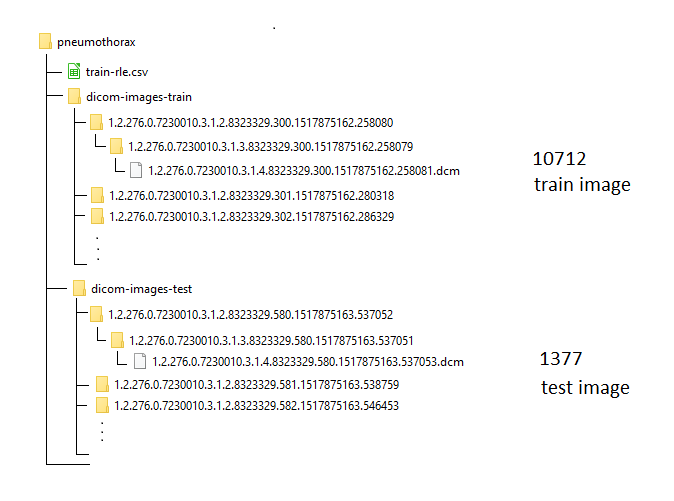

Now, let's see some code. To access the dataset to the kaggle notebook, I found useful [See--](https://www.kaggle.com/seesee)'s [kernel](https://www.kaggle.com/seesee/full-dataset). I have uploaded the full dataset to Workspace, and I could read the dcm files.

In [1]:
from glob import glob
import os
import pandas as pd

#checnking the input files
print(os.listdir("../input/siim-acr-pneumothorax-segmentation-data"))

#reading all dcm files into train and text
train = sorted(glob("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/*/*/*.dcm"))
test = sorted(glob("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-test/*/*/*.dcm"))
print("train files: ", len(train))
print("test files: ", len(test))

pd.reset_option('max_colwidth')

#reading the csv
print("the csv with the labels: -1 means no Pneumothorax, othervise there is an encoding for the place of Pneumothorax")
masks = pd.read_csv("../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/train-rle.csv", delimiter=",")
masks.head()

['dicom-images-test', 'dicom-images-train', 'pneumothorax', 'train-rle.csv']
train files:  10712
test files:  1377
the csv with the labels: -1 means no Pneumothorax, othervise there is an encoding for the place of Pneumothorax


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


Let's start with the DICOM files. Fortunately, Python has a library called [pydicom](https://pydicom.github.io/pydicom/stable/getting_started.html) for reading them. As we can see below, a lot of metadata are available beside the x-ray image, but only a few of them may be useful for us. This patient, 38 years old man, is lucky, he has no Pneumothorax.

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '17d405a3-a0d2-4901-b33a-63906aa48d9f'
(0010, 0020) Patient ID                          LO: '17d405a3-a0d2-4901-b33a-63906aa48d9f'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

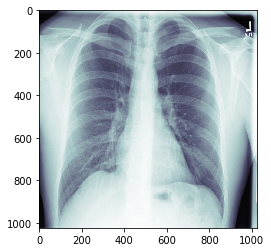

In [2]:
import pydicom
import matplotlib.pyplot as plt

#displaying the image
img = pydicom.read_file(train[0]).pixel_array
plt.imshow(img, cmap='bone')
plt.grid(False)

#displaying metadata
data = pydicom.dcmread(train[0])
print(data)

<a class="anchor" id="section4"></a>
## 4. Exploring the train metadata 

In [3]:
#dataframe to ease the access
patients = []
missing = 0

pd.reset_option('max_colwidth')

for t in train:
    data = pydicom.dcmread(t)
    patient = {}
    patient["UID"] = data.SOPInstanceUID
    try:
        encoded_pixels = masks[masks["ImageId"] == patient["UID"]].values[0][1]
        patient["EncodedPixels"] = encoded_pixels
    except:
        missing = missing + 1
    patient["Age"] = data.PatientAge
    patient["Sex"] = data.PatientSex
    patient["Modality"] = data.Modality
    patient["BodyPart"] = data.BodyPartExamined
    patient["ViewPosition"] = data.ViewPosition
    patient["path"] = "../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/" + data.StudyInstanceUID + "/" + data.SeriesInstanceUID + "/" + data.SOPInstanceUID + ".dcm"
    patients.append(patient)

print("missing labels: ", missing)
#pd.set_option('display.max_colwidth', -1)
df_patients = pd.DataFrame(patients, columns=["UID", "EncodedPixels", "Age", "Sex", "Modality", "BodyPart", "ViewPosition", "path"])
print("images with labels: ", df_patients.shape[0])
df_patients.head()

missing labels:  37
images with labels:  10712


,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38,M,CR,CHEST,PA,../input/siim-acr-pneumothorax-segmentation-da...
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10,F,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50,F,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68,F,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65,M,CR,CHEST,AP,../input/siim-acr-pneumothorax-segmentation-da...


It seems that some images are missing based on the csv file. Anyway, now we have a dataframe which ease to visualize some aspects of the train metadata. First, let's see the gender and diagnosis distributions.

<a class="anchor" id="section4a"></a>

5903 4809
8296 2416
4554 1349 3742 1067


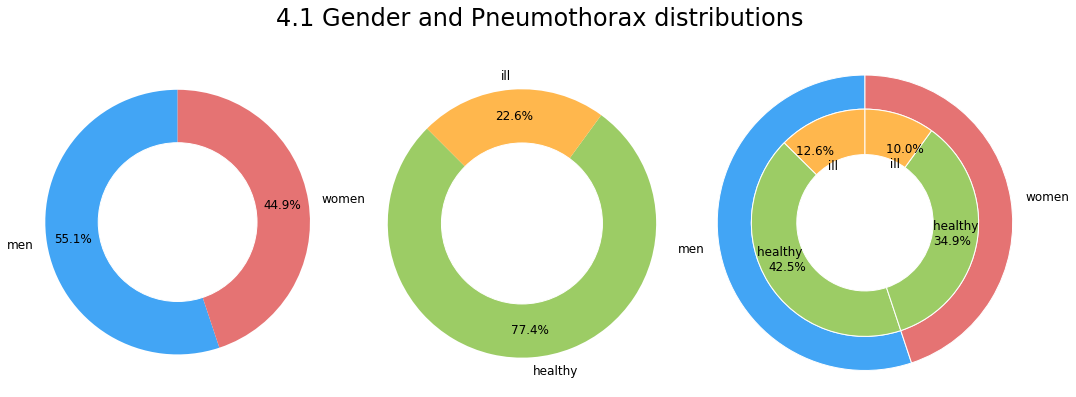

In [4]:
import matplotlib as mpl
import numpy as np

#gender
men = df_patients[df_patients["Sex"] == "M"].shape[0]
women = df_patients.shape[0] - men
print(men, women)


#illness
healthy = df_patients[df_patients["EncodedPixels"] == " -1"].shape[0]
ill = df_patients.shape[0] - healthy
print(healthy, ill)

#gender + illness
men_h = df_patients[(df_patients["Sex"] == "M") & (df_patients["EncodedPixels"] == " -1")].shape[0]
men_ill = men - men_h
women_h = df_patients[(df_patients["Sex"] == "F") & (df_patients["EncodedPixels"] == " -1")].shape[0]
women_ill = women - women_h
print(men_h, men_ill, women_h, women_ill)

perc = [str(round(men_ill/107.12, 1)) + "% \n ill", "healthy \n" + str(round(men_h/107.12, 1)) + "%", "healthy \n" + str(round(women_h/107.12, 1)) + "%",str(round(women_ill/107.12, 1)) + "% \n ill"]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("4.1 Gender and Pneumothorax distributions", fontsize=24, y=1.1)

mpl.rcParams['font.size'] = 12.0

#circle for donut chart
circle0 = plt.Circle( (0,0), 0.6, color = 'white')
circle1 = plt.Circle( (0,0), 0.4, color = 'white')
circle2 = plt.Circle( (0,0), 0.6, color = 'white')

#men women
ax[0].pie([men, women], labels=["men", "women"], colors=["#42A5F5", "#E57373"], autopct='%1.1f%%', pctdistance=0.8, startangle=90)
ax[0].add_patch(circle0)
ax[0].axis('equal')

#gender healthy
mypie, _ = ax[2].pie([men, women], radius=1.3, labels=["men", "women"], colors=["#42A5F5", "#E57373"], startangle=90)
plt.setp( mypie, width=0.3, edgecolor='white')

mypie2, _ = ax[2].pie([ men_ill, men_h, women_h, women_ill], radius = 1.3 - 0.3, labels=perc, labeldistance=0.61,
                      colors = ["#FFB74D", "#9CCC65", "#9CCC65", "#FFB74D"], startangle=90)
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

#healthy ill
ax[1].pie([healthy, ill], labels=["healthy", "ill"], colors=["#9CCC65", "#FFB74D"], autopct='%1.1f%%', pctdistance=0.8, startangle=135)
ax[1].add_patch(circle2)
ax[1].axis('equal')  

plt.tight_layout()
plt.show()

There are a bit more of men, so in proportion with that, there are a bit more men with Pneumothorax than women. We also know the age of patients, so let's see the age distribution. To create a histogram, we have to know the maximum ages, for example by sorting.

In [5]:
import numpy as np
#group into bins the same aged men and women with histogram --> all of them and ill of them

#convert he Age column to int
df_patients["Age"] = pd.to_numeric(df_patients["Age"])

sorted_ages = np.sort(df_patients["Age"].values)
print(sorted_ages)

[  1   2   2 ...  94 148 413]


Oops, it's seems there are errors in the dataset, 413 is far to old, and the 148 is also unbeliveable. For the histogram, I will skip these two values.

<a class="anchor" id="section4b"></a>

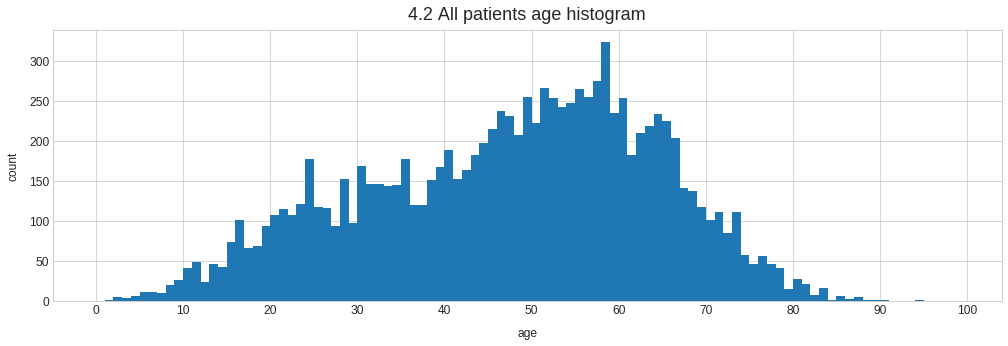

In [6]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(17, 5))
plt.hist(sorted_ages[:-2], bins=[i for i in range(100)])
plt.title("4.2 All patients age histogram", fontsize=18, pad=10)
plt.xlabel("age", labelpad=10)
plt.xticks([i*10 for i in range(11)])
plt.ylabel("count", labelpad=10)
plt.show()

To find out more about the occurence of Pneumothorax at different ages and genders, we can create a plot like the following:

<a class="anchor" id="section4c"></a>

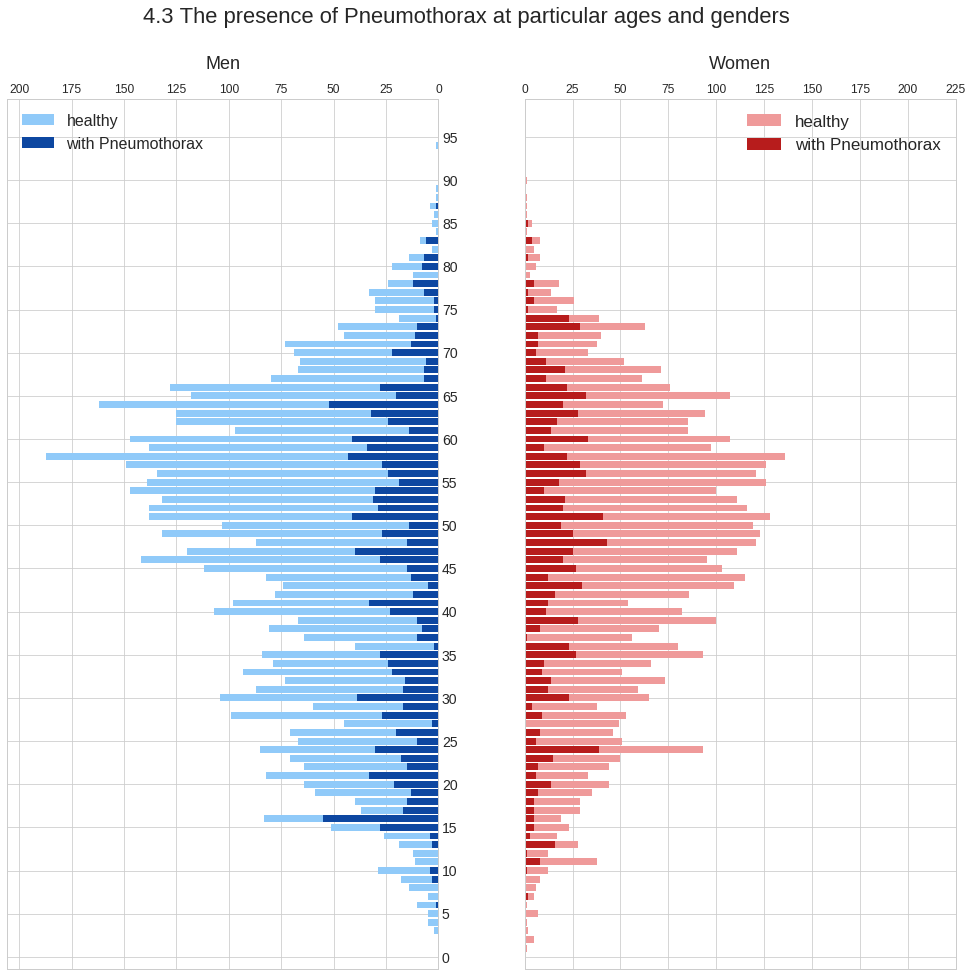

In [7]:
#calculating all and ill men and women histograms
bins = [i for i in range(100)]
plt.style.use('seaborn-whitegrid')

all_men = np.histogram(df_patients[df_patients["Sex"] == "M"]["Age"].values, bins=bins)[0]
all_women = np.histogram(df_patients[df_patients["Sex"] == "F"]["Age"].values, bins=bins)[0]

ill_men = np.histogram(df_patients[(df_patients["Sex"] == "M") & (df_patients["EncodedPixels"] != ' -1')]["Age"].values, bins=bins)[0]
ill_women = np.histogram(df_patients[(df_patients["Sex"] == "F") & (df_patients["EncodedPixels"] != ' -1')]["Age"].values, bins=bins)[0]

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(17, 16))

fig.suptitle("4.3 The presence of Pneumothorax at particular ages and genders", fontsize=22, y=0.96)

axes[0].margins(x=0.1, y=0.01)
m1 = axes[0].barh(bins[:-1], all_men, color='#90CAF9')
m2 = axes[0].barh(bins[:-1], ill_men, color='#0D47A1')
axes[0].set_title('Men', fontsize=18, pad=15)
axes[0].invert_xaxis()
axes[0].set(yticks=[i*5 for i in range(20)])
axes[0].tick_params(axis="y", labelsize=14)
axes[0].yaxis.tick_right()
axes[0].xaxis.tick_top()
axes[0].legend((m1[0], m2[0]), ('healthy', 'with Pneumothorax'), loc=2, prop={'size': 16})

locs = axes[0].get_xticks()

axes[1].margins(y=0.01)
w1 = axes[1].barh(bins[:-1], all_women, color='#EF9A9A')
w2 = axes[1].barh(bins[:-1], ill_women, color='#B71C1C')
axes[1].set_title('Women', fontsize=18, pad=15)
axes[1].xaxis.tick_top()
axes[1].set_xticks(locs)
axes[1].legend((w1[0], w2[0]), ('healthy', 'with Pneumothorax'), prop={'size': 17})

#for i, v in enumerate(depos["ItemViewCount"].values):
   #print(i, v)
    #axes[1].text(int(v) + 3, int(i)-0.25, str(v))
plt.show()

It is striking that many 16-year-old boys suffer from Pneumothorax, even more than the 64 years old men. The result seems unexpected, but if we read more about the disease, it turns out that the [young, tall and thin men](https://edmonton.ctvnews.ca/tall-thin-young-man-you-could-suffer-from-a-collapsed-lung-1.1234203) are more vulnerable. Young women in their twenties don't seem to be an exception. However this information is based only on a small amount of data.

Next let's check the other extracted attributes: Modality, BodyPart, ViewPosition.

In [8]:
bodypart = df_patients["BodyPart"].values
print("Body parts:", list(set(bodypart)))

modality = df_patients["Modality"].values
print("Modality:", list(set(modality)))

view = list(df_patients["ViewPosition"].values)
print("View Positions: ", list(set(view)))

pa = view.count("PA")
ap = view.count("AP")
print(pa, ap)

Body parts: ['CHEST']
Modality: ['CR']
View Positions:  ['PA', 'AP']
6507 4205


Text(0.5, 1.0, 'Occurrences of View positions')

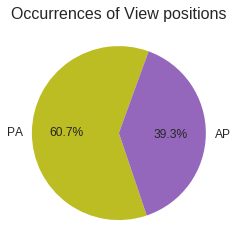

In [9]:

basic_palette = sns.color_palette()
plt.style.use('seaborn-whitegrid')
plt.pie([pa, ap], labels = ["PA", "AP"], colors=[basic_palette[-2], basic_palette[4]], autopct='%1.1f%%', startangle=70)
plt.title("Occurrences of View positions", fontsize=16)

As we expected, all the BodyPart fields are chests, the modality is CR, which means Computed Radiography (I think). 

<a class="anchor" id="section4d"></a>
### 4.4 The importance of view positions on an x-ray image 

The view position can be AP or PA. These refer to the way of x-ray in the body, [based on this source](https://www.quora.com/What-is-the-difference-between-an-AP-and-a-PA-view-of-an-X-ray)
* PA: passes from posterior of the body to anterior --> getting better anterior shadings
* AP: passes from anterior of the body to posterior --> getting better posterior shaginds

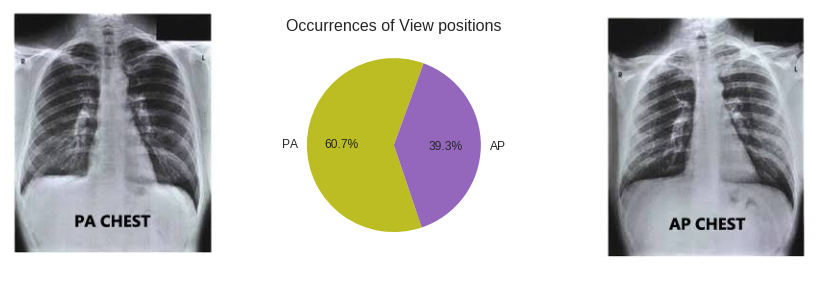

They say usually AP view is used for x-rays, but in the case of the chest x-rays are rather taken from the PA view. If the health level of the patient does not allow to do PA, AP can also help. It would be interesting to check the Pneumothorax severity level in relation to view position too. But first, we have to decode the run-length-encoding (RLE) present int the train csv file. 

<a class="anchor" id="section5"></a>
## 5. The run-length-encoding 

So as we could see, the train csv contains the image id and the rle-encodings of the place of Pneumothorax. But what does this mean? Run-length-encoding (RLE) is a simple lossless compression method, it replaces data sequences with identical values (run) with the respective value stored once and the length of the run. It can be useful when the data contains relatively long sequences. Here is a very simple example. 

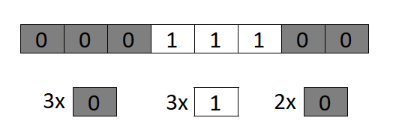

We have to work with **relative** RLE, which means, that the pixel locations are measured from the previous run. For example, '1 3 10 5' implies pixels 1,2,3 are to be included in the mask, as well as 14,15,16,17,18, according to [Robin Schwob](https://www.kaggle.com/schwobr) in this [discussion](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/98397#latest-567740).

<a class="anchor" id="section5a"></a>
### 5.1 Mask functions
Fortunately there are decoding and encoding functions inculded to the sample data: mask_functions.py. As I would like to analyze the train data rle labels, I will use only the rle2mask function. Let's check how it is working.

In [10]:
#mask functions from sample dataset
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

Here are two examples of the encoded pixels. The rle2mask function returns a filter which has the same size as the original image. Some rotation and mirroring were needed, to place the mask correctly.

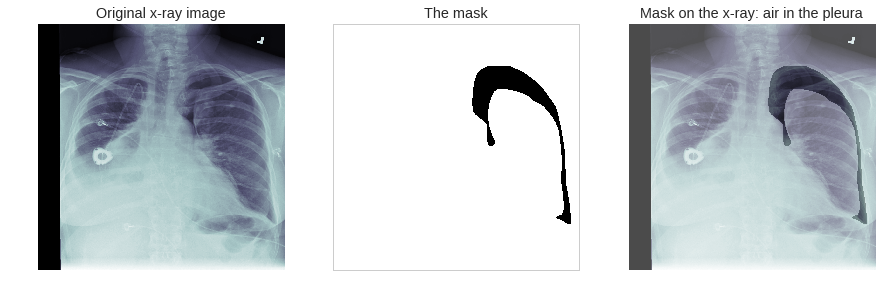

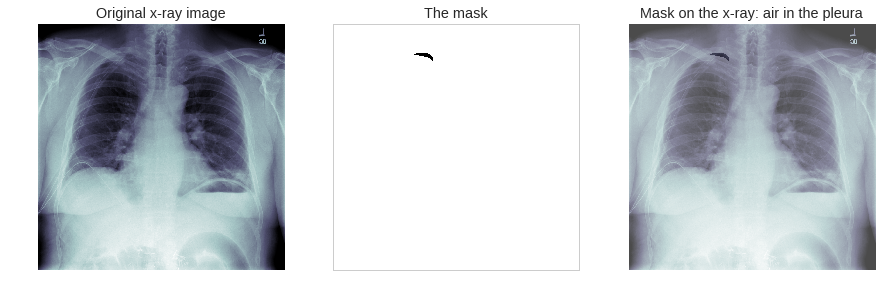

In [11]:
df_pneumo = df_patients[df_patients["EncodedPixels"] != ' -1']

#print(df_pneumo.values[3][2], df_pneumo.values[3][3])

mask = rle2mask(df_pneumo.values[3][1], 1024, 1024)
mask = np.rot90(mask, 3) #rotating three times 90 to the right place
mask = np.flip(mask, axis=1)
img = pydicom.read_file(df_pneumo.values[3][-1]).pixel_array

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray: air in the pleura")

plt.axis("off")

plt.grid(False)

mask = rle2mask(df_pneumo.values[6][1], 1024, 1024)
mask = np.rot90(mask, 3) #rotating three times 90 to the right place
mask = np.flip(mask, axis=1)
img = pydicom.read_file(df_pneumo.values[6][-1]).pixel_array

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray: air in the pleura")

plt.axis("off")

plt.grid(False)

Now that we can decode the rle, we can analyze some aspects of the masks separately and together with the metadata. Let's start with the area of the air in the chest, which could measure the severity of the disease.

<a class="anchor" id="section6"></a>
## 6. Analyzing the masks

As the masks are created from pixels, we can eaisly count them to calculate the area. As we can see the majority of ill patients suffer from a smaller Pneumothorax, and some patients have a severely collapsed lung. Note: we didn't take in consideration the overlapping masks, just the masked pixels, and at some images the scale may differ too.

In [12]:
area = []
pos = []
pa_area = []
ap_area = []

c = 0

for p in df_pneumo.values:
    try:
        mask = rle2mask(p[1], 1024, 1024)
        pixels = np.count_nonzero(mask)
        area.append(pixels)
        pos.append(p[6])
        if p[6] == "AP":
            ap_area.append(pixels)
        else:
            pa_area.append(pixels)
    except:
        c = c + 1

print("missing labels", c)
print("all area", np.sort(np.array(area)))
#print("ap area", np.sort(np.array(ap_area)))
print("pa area", np.sort(np.array(pa_area)))

missing labels 37
all area [    55     80    201 ... 134354 145885 161421]
pa area [    80    210    212 ...  87976 102743 104516]


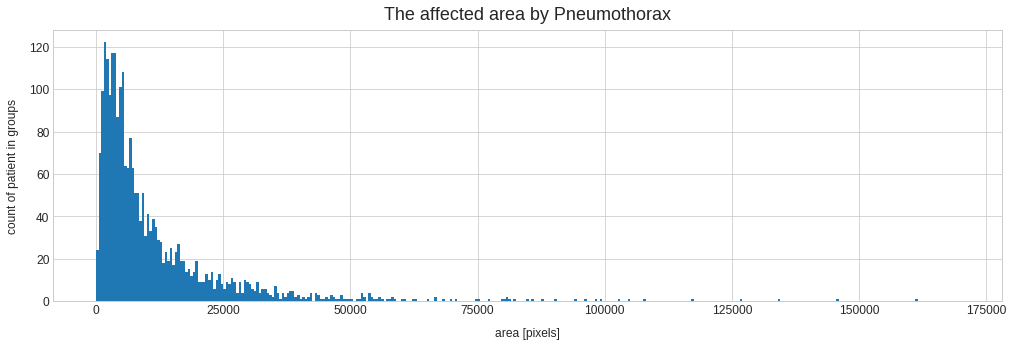

In [13]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(17, 5))
plt.hist(area, bins=[i*500 for i in range(340)])
plt.title("The affected area by Pneumothorax", fontsize=18, pad=10)
plt.xlabel("area [pixels]", labelpad=10)
#plt.xticks([i*10 for i in range(1000)])
plt.ylabel("count of patient in groups", labelpad=10)
plt.show()

<a class="anchor" id="section6a"></a>
### 6.1 The affected area and the view position

As mentioned before, let's see if the "AP" positioned x-ray images has a more serious Pneumothorax? On the plots below can be seen that this supposition tend to be true. The x-ray images with the biggest masks are made in AP position, howewer, this view position occurs fewer times than PA.

Text(0.5, 1.0, 'Occurrences of View positions')

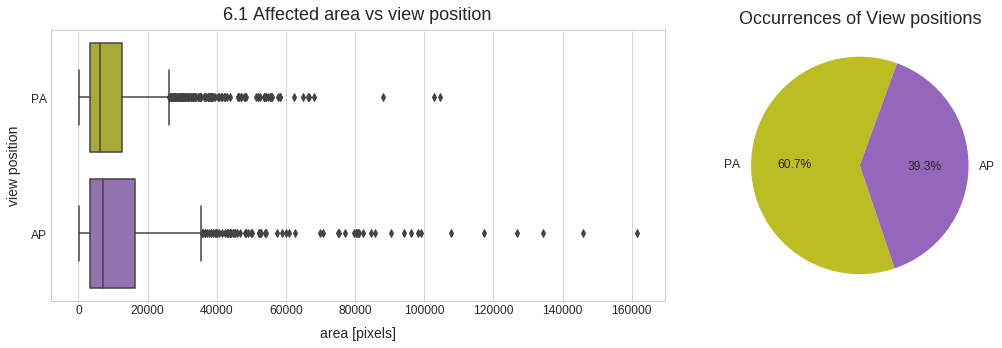

In [14]:
fig = plt.figure(figsize=(17, 5))
basic_palette = sns.color_palette()

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)

sns.boxplot(x=area, y=pos, palette={"AP": basic_palette[4], "PA": basic_palette[-2]})#, height=[0.6, 0.4])
ax1.set_xlabel("area [pixels]", fontsize=14, labelpad=10)
ax1.set_ylabel("view position", fontsize=14, labelpad=10)
ax1.set_title("6.1 Affected area vs view position", fontsize=18, pad=10)

ax2 = plt.subplot2grid((1, 3), (0, 2))

ax2.pie([pa, ap], labels = ["PA", "AP"], colors=[basic_palette[-2], basic_palette[4]], autopct='%1.1f%%', startangle=70)
ax2.set_title("Occurrences of View positions", fontsize=18)


<a class="anchor" id="section6b"></a>
### 6.2 The location of Pneumothorax

To get a general insight into the location of Pneumothorax, we can create some "lung heatmaps" for  AP and PA views. Of course, every patient is different, thus the size of the lungs and their place on the x-ray image can be different. However, a heatmap may give an overview.

In [15]:
c = 0
ap_sum = np.array([[0 for i in range(1024)] for j in range(1024)])
pa_sum = np.array([[0 for i in range(1024)] for j in range(1024)])

ap = 0
pa = 0

for p in df_pneumo.values:
    try :
        mask = rle2mask(p[1], 1024, 1024)
        mask = np.rot90(mask, 3) #rotating three times 90 to the right place
        mask = np.flip(mask, axis=1)
        if p[6] == 'AP':
            ap_sum = ap_sum + mask
            ap = ap + 1
        else:
            pa_sum = pa_sum + mask
            pa = pa + 1
    except:
        c = c + 1

([], <a list of 0 Text yticklabel objects>)

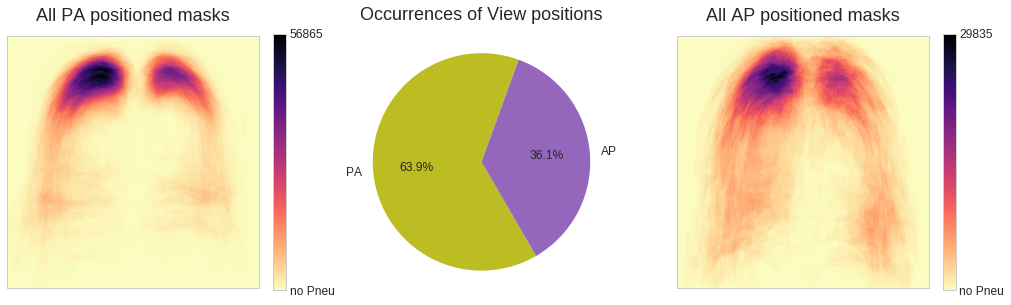

In [16]:
fig = plt.figure(figsize=(17, 5))
basic_palette = sns.color_palette()

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax1.imshow(pa_sum, cmap='magma_r')
ax1.set_title("All PA positioned masks", fontsize=18, pad=15)

#colorbar
maxval = np.max(pa_sum)
cmap = plt.get_cmap('magma_r', maxval)

norm = mpl.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ticks=[1/(maxval+1)/2, 0.5, 1-1/(maxval+1)/2]

cb_1 = plt.colorbar(sm,ticks=[0, 1], fraction=0.046, ax=ax1)#ticks and boundaries
cb_1.ax.set_yticklabels(["no Pneu", str(int(maxval))]) #label of colormap
cb_1.ax.yaxis.set_label_position('left')

plt.grid(False)
plt.xticks([])
plt.yticks([])

ax2 = plt.subplot2grid((1, 3), (0, 1))
ax2.pie([pa, ap], labels = ["PA", "AP"], colors=[basic_palette[-2], basic_palette[4]], autopct='%1.1f%%', startangle=70)
ax2.set_title("Occurrences of View positions", fontsize=18)

ax3 = plt.subplot2grid((1, 3), (0, 2))
ax3.imshow(ap_sum, cmap='magma_r')
ax3.set_title("All AP positioned masks", fontsize=18, pad=15)

maxval = np.max(ap_sum)
cmap2 = plt.get_cmap('magma_r', maxval)

norm = mpl.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_2 = plt.colorbar(sm,ticks=[0, 1], fraction=0.046, ax=ax3)#ticks and boundaries
cb_2.ax.set_yticklabels(["no Pneu", str(int(maxval))]) #label of colormap
cb_2.ax.yaxis.set_label_position('left')

plt.grid(False)
plt.xticks([])
plt.yticks([])

It seems that in both cases the top left corner of the lung is the most common location. In the PA cases, the x-ray images create a cleaner view, the lungs are outlined, while the general lungs of AP cases are noisier and have orange tone. From the colorbar can be read the maximum number of overlapped pixels.

<a class="anchor" id="section7"></a>
## 7. Conclusion

So these were some brief explorations to get a bit more insight into the dataset and its metadata. We have seen the gender and age distributions of healthy and ill people, we discovered more about the x-ray image view positions and about the affected areas. Hopefully, it was useful to understand a bit the nature of the disease and of the affected people.